# Kernel Approximation

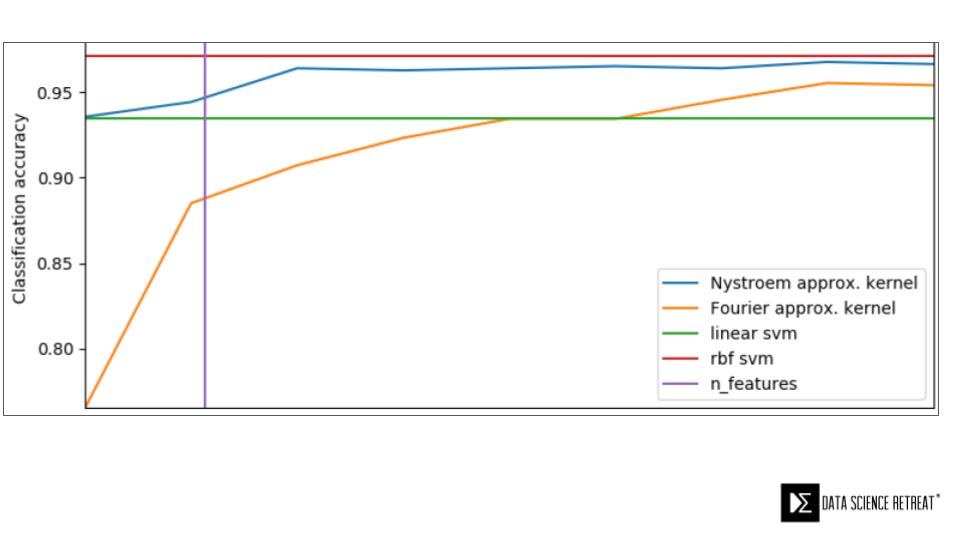

In [1]:
# used 2 kernel approximation methods for SVC,
# because i never see a nonlinear SVC model finished due to high amount of data 
# thus approximated rbf features with furye and niystrom transformation and on top of it i applied LinearSVC. 
# see these kernel approximations are performing very close to regular SVC with enough data set. 
# This saved me lots of time.

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn import svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import log_loss

In [22]:
#import data

datadir ="../../Notebooks/24March18/numerai_dataset_99/"
df_train = pd.read_csv(datadir + "numerai_training_data.csv")
df_tournament = pd.read_csv(datadir + "numerai_tournament_data.csv")
df_valid = df_tournament[df_tournament['data_type'].isin(['validation'])]

feature_cols = [f for f in df_train.columns if "feature" in f]
target_col = df_train.columns[-1]

In [21]:
df_train.groupby("era").target.value_counts() # equally distributed

era     target
era1    0          824
        1          824
era10   0         1274
        1         1274
era100  0         1889
        1         1888
era101  0         1903
        1         1903
era102  0         1964
        1         1964
era103  0         1871
        1         1870
era104  0         1870
        1         1870
era105  0         1822
        1         1822
era106  0         1882
        1         1882
era107  0         1829
        1         1828
era108  0         1538
        1         1537
era109  0         1781
        1         1780
era11   0         1226
        1         1226
era110  0         1856
        1         1856
era111  0         1860
        1         1859
                  ... 
era86   0         1722
        1         1721
era87   0         1844
        1         1843
era88   0         1838
        1         1837
era89   0         1831
        1         1831
era9    0         1208
        1         1207
era90   0         1811
        1         1

# Sampling Numerai Data set

to create a meaningful sample data set
data should be equally distributed both in target labels
and training data should present each era, 
one can use pandas sample feature or sklearn traintestsplit is fine.

In [74]:
df_train_s = df_train.sample(frac=0.5,random_state=5)

In [75]:
x_tr,x_te,y_tr,y_te = train_test_split(df_train, df_train.target,test_size =0.5)

In [76]:
df_train_s.target.value_counts() # almost equally distributed

0    98430
1    98376
Name: target, dtype: int64

In [77]:
x_te.target.value_counts() # almost equally distributed

0    98425
1    98382
Name: target, dtype: int64

In [78]:
x_te.groupby("era").target.value_counts()

era     target
era1    1          400
        0          397
era10   0          628
        1          615
era100  1          953
        0          945
era101  0          945
        1          944
era102  1         1005
        0          984
era103  1          927
        0          923
era104  0          936
        1          930
era105  1          966
        0          935
era106  0          947
        1          913
era107  0          944
        1          928
era108  1          785
        0          755
era109  1          912
        0          885
era11   1          646
        0          594
era110  0          940
        1          934
era111  0          959
        1          932
                  ... 
era86   1          863
        0          847
era87   1          914
        0          886
era88   1          921
        0          897
era89   0          917
        1          881
era9    0          602
        1          593
era90   0          949
        1          

In [79]:
df_train_s.groupby("era").target.value_counts()

era     target
era1    1         410
        0         398
era10   0         639
        1         632
era100  1         954
        0         921
era101  0         971
        1         954
era102  1         991
        0         972
era103  0         952
        1         908
era104  0         967
        1         933
era105  0         982
        1         899
era106  0         982
        1         936
era107  1         945
        0         913
era108  0         789
        1         765
era109  1         914
        0         905
era11   0         638
        1         598
era110  0         965
        1         917
era111  0         971
        1         950
                 ... 
era86   1         873
        0         834
era87   0         931
        1         893
era88   0         942
        1         879
era89   0         941
        1         927
era9    0         626
        1         606
era90   0         905
        1         849
era91   0         843
        1        

# Feature Map with Fourier and Nystroem

create features from fourier transfrom and nystrom techniques
these two methods are basically to approximate non linear svc scores.
as you can see the kernel svc i.e the non linear svc takes lots of time.

In [ ]:
feature_map_fourier = RBFSampler(gamma=.2, random_state=1,n_components=200)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1, n_components=200)

Lsvm = svm.LinearSVC(C=1e-2)

fourier_approx_Lsvm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC(C=1e-2))])


nystroem_approx_Lsvm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC(C=1e-2))])

Ksvm = svm.SVC(C=1e-2,cache_size=12000)

clfs = [Lsvm, fourier_approx_Lsvm, nystroem_approx_Lsvm, Ksvm]

# fit and predict using linear , kernel approximated and kernel svm:

for clf in clfs:
    start = time()  
    clf.fit(df_train_s[feature_cols].values,df_train_s[target_col])
    finish = time() - start 
    y_pred = clf.predict(df_valid[feature_cols].values)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(df_valid[feature_cols].values)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(df_valid[feature_cols].values)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
       
    print("Classifier:",clf)
    print("\tLogLoss: %1.6f" % log_loss(df_valid[target_col].values, prob_pos))
    print("Duration is {}".format(finish))
    

Classifier: LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	LogLoss: 0.721771
Duration is 1.6056413650512695
Classifier: Pipeline(memory=None,
     steps=[('feature_map', RBFSampler(gamma=0.2, n_components=200, random_state=1)), ('svm', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	LogLoss: 0.727258
Duration is 4.64762544631958
Classifier: Pipeline(memory=None,
     steps=[('feature_map', Nystroem(coef0=None, degree=None, gamma=0.2, kernel='rbf', kernel_params=None,
     n_components=200, random_state=1)), ('svm', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     m

# Consistency check for eras with threshold 75 percent

In [5]:
df_valid['pf']=prob_pos
from math import log
eras = df_valid.era.unique()
good_eras = 0
for era in eras:

    tmp = df_valid[ df_valid.era == era ]
    ll = log_loss( tmp.target, tmp.pf)
    is_good = ll < -log( 0.5 )

    if is_good:
        good_eras += 1

    print( "{} {} {:.2%} {}".format( era, len( tmp ), ll, is_good ))

consistency = good_eras / float( len( eras ))
print( "\nconsistency: {:.1%} ({}/{})".format( consistency, good_eras, len( eras )))


era86 6091 69.06% True
era87 6079 68.87% True
era88 6067 69.29% True
era89 6064 69.41% False
era90 6050 68.96% True
era91 6027 69.27% True
era92 6048 69.40% False
era93 6038 69.44% False
era94 6326 68.80% True
era95 6349 69.07% True
era96 6336 69.21% True
era97 6390 69.26% True

consistency: 75.0% (9/12)


/home/forestclubb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Save predictions if consistency criterion is passed

In [6]:
if consistency > 0.74:       
    if hasattr(clf, "predict_proba"):
        p_tournament = clf.predict_proba(df_tournament[feature_cols])[:, 1]                
    else:  # use decision function
        p_tournament = clf.decision_function(d)               
        p_tournament = (p_tournament - p_tournament.min()) / (p_tournament.max() - p_tournament.min())

    df_pred_tournament = pd.DataFrame({
        'id': df_tournament['id'],
        'probability': p_tournament
        })
    ll=log_loss(targets_test, prob_pos)
    csv_path = './predictions_{}_{}.csv'.format(int(time.time()), str(ll)[2:])
    df_pred_tournament.to_csv(csv_path, columns=('id', 'probability'), index=None)
    print('Saved: {}'.format(csv_path))